## Lab 3
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os
import time

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from torch.utils.data import DataLoader, Dataset, Subset


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))

fmnist_dataset_train = torchvision.datasets.FashionMNIST(
    root_path, 
    train=True, 
    transform=train_transform,
    target_transform=None,
    download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(
    root_path, 
    train=False, 
    transform=test_transform,
    target_transform=None,
    download=download)

In [4]:
print(f"""
Full train set len: {len(fmnist_dataset_train)},
test set len: {len(fmnist_dataset_test)}
""")


Full train set len: 60000,
test set len: 10000



In [5]:
def subset_ind(dataset, ratio: float):
    return np.random.choice(len(dataset), size=int(ratio*len(dataset)), replace=False)

Let's define a function for training our models.

In [6]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int):
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            opt.zero_grad()
            # move data to target device
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            predictions = model(X_batch)
            loss = loss_fn(predictions, y_batch)
            loss.backward()
            opt.step()
            ep_train_loss.append(loss.item())

        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # move data to target device
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                # compute predictions
                predictions = model(X_batch)
                loss = loss_fn(predictions, y_batch)
                ep_val_loss.append(loss.item())
                y_pred = predictions.max(1)[1].data
                ep_val_accuracy.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))

        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        
        print(f"\t      training loss: {train_loss[-1]:.6f}")
        print(f"\t    validation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy

And also function for testing.

In [7]:
def test_model(model, test_loader, loss_fn):
    test_loss = []
    test_accuracy = []
    model.train(False)
    with torch.no_grad():
        for X_batch, y_batch in train_loader:
            # move data to target device
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            # compute predictions
            predictions = model(X_batch)
            loss = loss_fn(predictions, y_batch)
            test_loss.append(loss.item())
            y_pred = predictions.max(1)[1].data
            test_accuracy.append(np.mean( 
                (y_batch.cpu() == y_pred.cpu()).numpy() 
            ))    
    return test_loss, test_accuracy

A helper-function for interpretability its quality w.r.t. accuracy and loss is defined below.

In [8]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()
    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)

In [9]:
val_ratio = 0.25
val_inds = subset_ind(fmnist_dataset_train, val_ratio)

fmnist_datasubset_train = Subset(
    fmnist_dataset_train,
    [i for i in range(len(fmnist_dataset_train)) if i not in val_inds]
)
fmnist_datasubset_val = Subset(fmnist_dataset_train, val_inds)

In [10]:
print(f"""
Full train set len: {len(fmnist_dataset_train)},
train subset len: {len(fmnist_datasubset_train)},
validation subset len: {len(fmnist_datasubset_val)},
test set len: {len(fmnist_dataset_test)}
""")


Full train set len: 60000,
train subset len: 45000,
validation subset len: 15000,
test set len: 10000



In [11]:
train_loader = DataLoader(
    fmnist_datasubset_train, 
    batch_size=128,
    shuffle=True,
    num_workers=2
)
val_loader = DataLoader(
    fmnist_datasubset_val, 
    batch_size=128,
    shuffle=True,
    num_workers=2
)
test_loader = DataLoader(
    fmnist_dataset_test,
    batch_size=256,
    shuffle=False,
    num_workers=2
)

### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [12]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, input_shape*2),
            nn.LeakyReLU(),
            nn.Dropout(p=0.6),
            nn.Linear(input_shape*2, num_classes)
        )
        
    def forward(self, inp):       
        self.out = self.model(inp)
        return self.out

In [13]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1568]       1,230,880
         LeakyReLU-3                 [-1, 1568]               0
           Dropout-4                 [-1, 1568]               0
            Linear-5                   [-1, 10]          15,690
Total params: 1,246,570
Trainable params: 1,246,570
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 4.76
Estimated Total Size (MB): 4.80
----------------------------------------------------------------


Experiments come here:

In [14]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()
n_epochs = 30

In [15]:
%%time
train_loss, val_loss, val_accuracy = train_model(model, train_loader, val_loader, loss_func, opt, n_epochs)

Epoch 1 of 30 took 17.879s
	      training loss: 0.596367
	    validation loss: 0.439842
	validation accuracy: 0.846
Epoch 2 of 30 took 14.898s
	      training loss: 0.454238
	    validation loss: 0.396338
	validation accuracy: 0.856
Epoch 3 of 30 took 13.697s
	      training loss: 0.416141
	    validation loss: 0.380878
	validation accuracy: 0.863
Epoch 4 of 30 took 17.266s
	      training loss: 0.393706
	    validation loss: 0.360868
	validation accuracy: 0.867
Epoch 5 of 30 took 18.006s
	      training loss: 0.383034
	    validation loss: 0.351361
	validation accuracy: 0.873
Epoch 6 of 30 took 16.606s
	      training loss: 0.367758
	    validation loss: 0.346546
	validation accuracy: 0.873
Epoch 7 of 30 took 15.718s
	      training loss: 0.356028
	    validation loss: 0.340638
	validation accuracy: 0.877
Epoch 8 of 30 took 13.933s
	      training loss: 0.347468
	    validation loss: 0.333992
	validation accuracy: 0.877
Epoch 9 of 30 took 14.177s
	      training loss: 0.341497
	    v

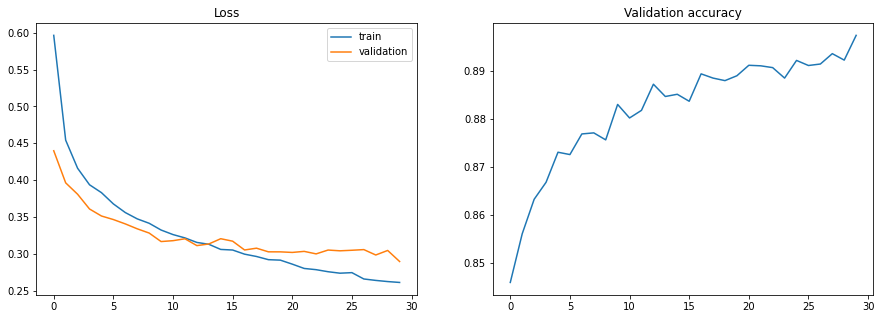

In [16]:
plot_train_process(train_loss, val_loss, val_accuracy)

The accuracy reaches 0.885 and even more on validation. The loss curve shows the lack of overfitting:)

In [17]:
%%time
test_loss, test_accuracy = test_model(model, test_loader, loss_func)

CPU times: user 4.53 s, sys: 451 ms, total: 4.98 s
Wall time: 5.73 s


In [18]:
print(f"""
test accuracy: {np.mean(test_accuracy)}
    test loss: {np.mean(test_loss)}
""")


test accuracy: 0.9265876538825757
    test loss: 0.19725906709209085



Tadaaaam, test accuracy is good!

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [19]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 1024),
            nn.LeakyReLU(),
            nn.Linear(1024, 2048),
            nn.LeakyReLU(),
            nn.Linear(2048, 128),
            nn.LeakyReLU(),
            nn.Linear(128, num_classes),
        )
        
    def forward(self, inp):       
        self.out = self.model(inp)
        return self.out

In [20]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
         LeakyReLU-3                  [-1, 128]               0
            Linear-4                  [-1, 512]          66,048
         LeakyReLU-5                  [-1, 512]               0
            Linear-6                 [-1, 1024]         525,312
         LeakyReLU-7                 [-1, 1024]               0
            Linear-8                 [-1, 2048]       2,099,200
         LeakyReLU-9                 [-1, 2048]               0
           Linear-10                  [-1, 128]         262,272
        LeakyReLU-11                  [-1, 128]               0
           Linear-12                   [-1, 10]           1,290
Total params: 3,054,602
Trainable params: 3,054,602
Non-trainable params: 0
---------------------------

Firstly, validation set should be extracted from the training one.

In [21]:
shrink_inds = subset_ind(fmnist_datasubset_train, 0.25)
overfitted_datasubset_train = Subset(fmnist_datasubset_train, shrink_inds)

In [22]:
print(f"""
Full train set len: {len(fmnist_dataset_train)},
train subset len: {len(fmnist_datasubset_train)},
overfitting subset len: {len(overfitted_datasubset_train)},
validation subset len: {len(fmnist_datasubset_val)},
test set len: {len(fmnist_dataset_test)}
""")


Full train set len: 60000,
train subset len: 45000,
overfitting subset len: 11250,
validation subset len: 15000,
test set len: 10000



In [23]:
overfitted_train_loader = DataLoader(
    overfitted_datasubset_train, 
    batch_size=128,
    shuffle=True,
    num_workers=2
)

In [24]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()
n_epochs = 30

In [25]:
%%time
train_loss, val_loss, val_accuracy = train_model(
    model, 
    train_loader, 
    val_loader, 
    loss_func, 
    opt, 
    n_epochs
)

Epoch 1 of 30 took 45.648s
	      training loss: 0.608708
	    validation loss: 0.472574
	validation accuracy: 0.825
Epoch 2 of 30 took 43.630s
	      training loss: 0.406011
	    validation loss: 0.386355
	validation accuracy: 0.856
Epoch 3 of 30 took 43.284s
	      training loss: 0.361663
	    validation loss: 0.374165
	validation accuracy: 0.858
Epoch 4 of 30 took 48.698s
	      training loss: 0.335074
	    validation loss: 0.372037
	validation accuracy: 0.861
Epoch 5 of 30 took 47.239s
	      training loss: 0.311168
	    validation loss: 0.340228
	validation accuracy: 0.872
Epoch 6 of 30 took 47.842s
	      training loss: 0.296445
	    validation loss: 0.347480
	validation accuracy: 0.881
Epoch 7 of 30 took 42.128s
	      training loss: 0.285998
	    validation loss: 0.348932
	validation accuracy: 0.874
Epoch 8 of 30 took 45.908s
	      training loss: 0.268987
	    validation loss: 0.317813
	validation accuracy: 0.885
Epoch 9 of 30 took 43.422s
	      training loss: 0.255613
	    v

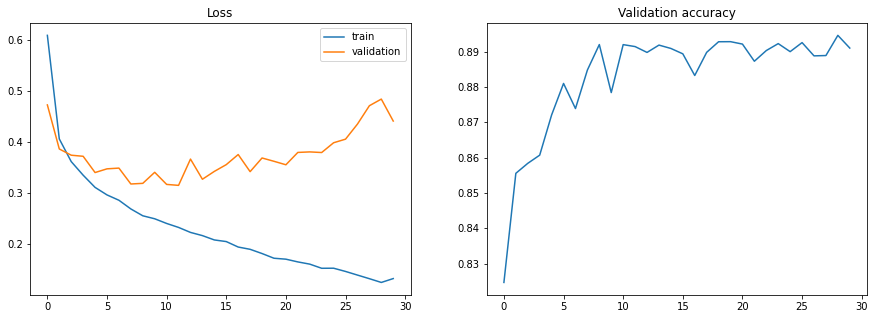

In [26]:
plot_train_process(train_loss, val_loss, val_accuracy)

In [27]:
%%time
test_loss, test_accuracy = test_model(model, test_loader, loss_func)

CPU times: user 8.73 s, sys: 792 ms, total: 9.52 s
Wall time: 8.18 s


In [28]:
print(f"""
test accuracy: {np.mean(test_accuracy)}
    test loss: {np.mean(test_loss)}
""")


test accuracy: 0.9512187302714646
    test loss: 0.12313803013900972



Okay, we built an overfitted network, validation loss increases.

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [29]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 128),
            nn.LeakyReLU(),
            nn.Dropout(p=0.6),
            nn.Linear(128, 512),
            nn.LeakyReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(p=0.6),
            nn.Linear(512, 1024),
            nn.LeakyReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(p=0.4),
            nn.Linear(1024, 2048),
            nn.LeakyReLU(),
            nn.BatchNorm1d(2048),
            nn.Dropout(p=0.45),
            nn.Linear(2048, 128),
            nn.LeakyReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, num_classes),
        )
        
    def forward(self, inp):       
        self.out = self.model(inp)
        return self.out

In [30]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
         LeakyReLU-3                  [-1, 128]               0
           Dropout-4                  [-1, 128]               0
            Linear-5                  [-1, 512]          66,048
         LeakyReLU-6                  [-1, 512]               0
       BatchNorm1d-7                  [-1, 512]           1,024
           Dropout-8                  [-1, 512]               0
            Linear-9                 [-1, 1024]         525,312
        LeakyReLU-10                 [-1, 1024]               0
      BatchNorm1d-11                 [-1, 1024]           2,048
          Dropout-12                 [-1, 1024]               0
           Linear-13                 [-1, 2048]       2,099,200
        LeakyReLU-14                 [-

In [31]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()
n_epochs = 30

In [32]:
%%time
train_loss, val_loss, val_accuracy = train_model(
    model, 
    train_loader, 
    val_loader, 
    loss_func, 
    opt, 
    n_epochs
)

Epoch 1 of 30 took 77.322s
	      training loss: 0.983155
	    validation loss: 0.580395
	validation accuracy: 0.778
Epoch 2 of 30 took 72.018s
	      training loss: 0.685605
	    validation loss: 0.512015
	validation accuracy: 0.816
Epoch 3 of 30 took 73.259s
	      training loss: 0.621164
	    validation loss: 0.509482
	validation accuracy: 0.814
Epoch 4 of 30 took 71.095s
	      training loss: 0.592698
	    validation loss: 0.442351
	validation accuracy: 0.842
Epoch 5 of 30 took 66.371s
	      training loss: 0.569710
	    validation loss: 0.440930
	validation accuracy: 0.847
Epoch 6 of 30 took 75.957s
	      training loss: 0.551536
	    validation loss: 0.439594
	validation accuracy: 0.842
Epoch 7 of 30 took 72.485s
	      training loss: 0.543531
	    validation loss: 0.464472
	validation accuracy: 0.835
Epoch 8 of 30 took 71.093s
	      training loss: 0.522947
	    validation loss: 0.418264
	validation accuracy: 0.852
Epoch 9 of 30 took 74.813s
	      training loss: 0.513709
	    v

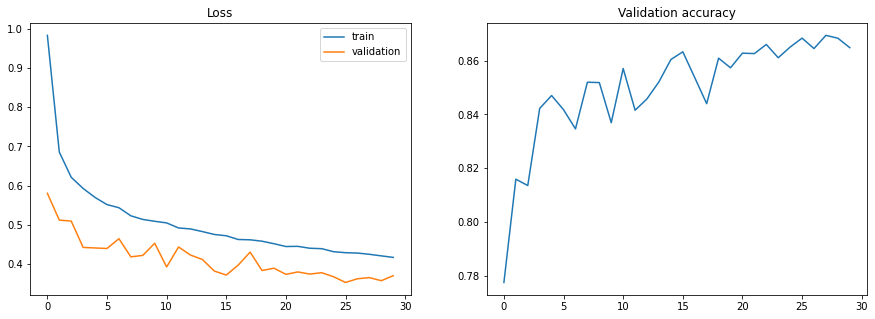

In [33]:
plot_train_process(train_loss, val_loss, val_accuracy)

In [34]:
%%time
test_loss, test_accuracy = test_model(model, test_loader, loss_func)

CPU times: user 8.68 s, sys: 1.12 s, total: 9.8 s
Wall time: 8.38 s


In [35]:
print(f"""
test accuracy: {np.mean(test_accuracy)}
    test loss: {np.mean(test_loss)}
""")


test accuracy: 0.8783661813446971
    test loss: 0.3253203646957197



### Conclusions:
*  We have built simple network that reaches $\geq 0.885$ test accuracy.
*  A network that overfits to this dataset was built. It consists from several linear layers and actiovation functions between them.
*  Fixed the overfitted network from the second step by using regularization techniques: batch normalization and dropout. Validation loss decreases on fixed network (at least partially).